In [1]:
# import libraries
import operator

# maths
import numpy as np
import pandas as pd

# visual

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KernelDensity

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=(FutureWarning, UserWarning))


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Preprocessing

In [2]:
# import data
    
df_fe = pd.read_csv('data/feature_engineered_merge.csv')

In [3]:
df_fe.shape

(126799, 43)

In [4]:
#variables dropped from analysis

df_fe.drop(['date', 'address', 'addressnumberandstreet', 'street'], axis=1, inplace=True)

### Dummy coding

Categorical variables were one hot encoded.

In [5]:
#going to dummy this
cat_list = ['codesum', 'sunset', 'trap', 'species']   


#dummy hot encoded
dummy_df= pd.get_dummies(df_fe[cat_list], drop_first=True)   

#drop original columns
df_fe.drop(cat_list, axis=1, inplace=True)


#concat the df into the df_over
df_fe = pd.concat([df_fe, dummy_df], axis=1)

### Date split: Train, Validation and Test (kaggle) set

In [6]:
# split to train and test before the bootstrapping

train = df_fe[df_fe['id'].isnull()]
kaggle_test = df_fe[df_fe['id'].notnull()]

In [7]:
# Prepare X and y

X = train.drop(columns=['nummosquitos', 'wnvpresent', 'id'])
y = train.wnvpresent


In [8]:
#train test split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify=y, random_state=42)

In [9]:
#have to merge for bootstrapping train set

df = pd.concat([X_train, y_train], axis=1)



In [10]:
#baseline = 94.7% 

y_validation.value_counts(normalize = True)

0.0    0.947469
1.0    0.052531
Name: wnvpresent, dtype: float64

## Random oversampling

We started by examining the different datasets and coming up with an overall framework on how we should approach the data cleaning process before splitting up the data cleaning work. We then combined the test, train and spray datasets and performed data visualisation and feature engineering on the combined dataset. The imbalanced dataset is a key challenge and we have attempted to address this with random oversampling.

7466 413
Random over-sampling:
1.0    7466
0.0    7466
Name: wnvpresent, dtype: int64


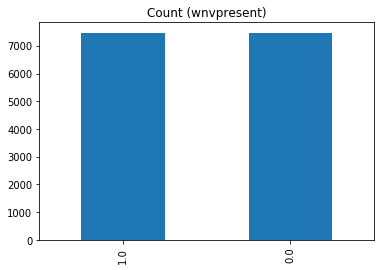

In [11]:
#count class

count_class_0, count_class_1 = df['wnvpresent'].value_counts()
print(count_class_0, count_class_1)

# Divide by class

df_class_0 = df[df['wnvpresent'] == 0]
df_class_1 = df[df['wnvpresent'] == 1]

#bootstrap into a new df

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over['wnvpresent'].value_counts())

df_over['wnvpresent'].value_counts().plot(kind='bar', title='Count (wnvpresent)');

In [12]:
X_train = df_over.drop(columns='wnvpresent')
y_train = df_over.wnvpresent

In [13]:
#check same column

print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(14932, 300)
(14932,)
(2627, 300)
(2627,)


## Modeling

Various modelling tools were used including Linear Regression, Random Forest, XGBoost and an ensemble of the three by max voting.  

### Logistic regression

In [23]:
#ransearch log reg

lr = LogisticRegression()

lr_values = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
               'C': np.logspace(-10, 10, 100)}


    
ran_lr = RandomizedSearchCV(lr, lr_values, cv=5, n_jobs = -1, random_state=42)
ran_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': ar...
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+

In [24]:
print(ran_lr.best_params_)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 32.745491628777316}


In [25]:
print ('lr classification metric')
print("CV scores:", ran_lr.best_score_)
print("train score:", ran_lr.score(X_train, y_train))
print("test score:", ran_lr.score(X_validation, y_validation))

#Evaluation metrics

predictions = ran_lr.predict(X_validation)

TN, FP, FN, TP = confusion_matrix(y_validation, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


print("True Negatives: %s" % TN)
print("False Positives: %s" % FP)
print("False Negatives: %s" % FN)
print("True Positives: %s" % TP)
print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in ran_lr.predict_proba(X_validation)]
auc_score = roc_auc_score(y_validation, pred_proba)
print('ROC AUC Score :', auc_score)

lr classification metric
CV scores: 0.8120137474490374
train score: 0.8234663809268685
test score: 0.7624666920441568
True Negatives: 1915
False Positives: 574
False Negatives: 50
True Positives: 88
-----------------------
Sensitivity: 0.638
Specificity: 0.769
Precision: 0.133
F1: 0.22
ROC AUC Score : 0.7903529151454808


### Random forest

In [27]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
               'max_features': ['auto', 'sqrt'],
               'n_estimators': [100, 200, 300, 400, 500]
              }


    
ran_rf = RandomizedSearchCV(rf, rf_values, cv=5, n_jobs = -1, random_state=42)
ran_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [28]:
print(ran_rf.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60}


In [29]:
print ('random forest classification metric')
print("CV scores:", ran_rf.best_score_)
print("train score:", ran_rf.score(X_train, y_train))
print("test score:", ran_rf.score(X_validation, y_validation))

#Evaluation metrics

predictions = ran_rf.predict(X_validation)

TN, FP, FN, TP = confusion_matrix(y_validation, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


print("True Negatives: %s" % TN)
print("False Positives: %s" % FP)
print("False Negatives: %s" % FN)
print("True Positives: %s" % TP)
print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in ran_rf.predict_proba(X_validation)]
auc_score = roc_auc_score(y_validation, pred_proba)
print('ROC AUC Score :', auc_score)

random forest classification metric
CV scores: 0.961491917083876
train score: 0.9733458344495044
test score: 0.9036924248191854
True Negatives: 2332
False Positives: 157
False Negatives: 96
True Positives: 42
-----------------------
Sensitivity: 0.304
Specificity: 0.937
Precision: 0.211
F1: 0.249
ROC AUC Score : 0.7786608905270145


### XGBoost

In [14]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1, )

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [200, 300, 400, 500]
              }


    
ran_xg = RandomizedSearchCV(xg, xg_values, cv=5, n_jobs = -1, random_state=42)
ran_xg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                                           validate_parameters=False,
                                           verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributi

In [15]:
print(ran_xg.best_params_)

{'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'gamma': 0, 'eta': 0.3}


In [16]:
print ('XGBoost classification metric')
print("CV scores:", ran_xg.best_score_)
print("train score:", ran_xg.score(X_train, y_train))
print("test score:", ran_xg.score(X_validation, y_validation))

#Evaluation metrics

predictions = ran_xg.predict(X_validation)

TN, FP, FN, TP = confusion_matrix(y_validation, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


print("True Negatives: %s" % TN)
print("False Positives: %s" % FP)
print("False Negatives: %s" % FN)
print("True Positives: %s" % TP)
print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in ran_xg.predict_proba(X_validation)]
auc_score = roc_auc_score(y_validation, pred_proba)
print('ROC AUC Score :', auc_score)

XGBoost classification metric
CV scores: 0.9130053406242858
train score: 0.9222475221001876
test score: 0.8363151884278645
True Negatives: 2124
False Positives: 365
False Negatives: 65
True Positives: 73
-----------------------
Sensitivity: 0.529
Specificity: 0.853
Precision: 0.167
F1: 0.253
ROC AUC Score : 0.8257899977291386


### Ensemble classifier with best params

In [14]:
model1 = LogisticRegression(solver = 'liblinear',penalty='l2', C=32.745491628777316)

model2 = RandomForestClassifier(n_estimators = 200, min_samples_split=5, min_samples_leaf=1,
                                max_features = 'sqrt', max_depth=60)

model3 = XGBClassifier(booster='gbtree', n_jobs=-1, n_estimators = 300,
                       max_depth = 3, reg_lambda = 0.5 , reg_alpha= 0.1,
                       gamma = 0, eta= 0.3 )

In [32]:

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

model = VotingClassifier(estimators=[('lr', model1), 
                                     ('rf', model2),
                                     ('xg', model3)], 
                         voting='soft')

model.fit(X_train,y_train)



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=32.745491628777316,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                 

In [33]:
print("Ensemble model classification metric")

kf=KFold(n_splits=5, shuffle=True, random_state=42)
print("cross val score:", cross_val_score(model, X_train, y_train, cv= kf).mean())
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_validation, y_validation))

#Evaluation metrics

predictions = model.predict(X_validation)

TN, FP, FN, TP = confusion_matrix(y_validation, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


print("True Negatives: %s" % TN)
print("False Positives: %s" % FP)
print("False Negatives: %s" % FN)
print("True Positives: %s" % TP)
print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in model.predict_proba(X_validation)]
auc_score = roc_auc_score(y_validation, pred_proba)
print('ROC AUC Score :', auc_score)

Ensemble model classification metric
cross val score: 0.9328950793918096
train score: 0.9479641039378516
test score: 0.8610582413399315
True Negatives: 2195
False Positives: 294
False Negatives: 71
True Positives: 67
-----------------------
Sensitivity: 0.486
Specificity: 0.882
Precision: 0.186
F1: 0.269
ROC AUC Score : 0.8147879655993618


![](images/score.png)

We fitted 3 models and an ensemble model by max vote using the 3 models (logistic regression, random forest and XGboost).
Scores on the XGBoost model was found to be the best based on ROC AUC of 0.826, which we used as our deciding factor on which model to choose as the ROC AUC would provide us with a score that tells us how well we are able to distinguish between presents of WNV and absence of WNV based on fitted variables. 


The XGBoost was then fitted to the test data set as a final model to make predictions. 

### Fit XGBoost model onto test set

XGBoost was selected based on the best ROC score of  0.826. A separate reference to Kaggle score of 0.625 was achieved with our model.

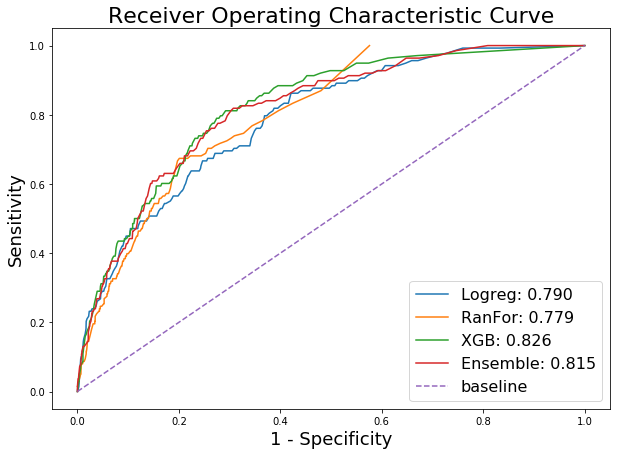

In [34]:
lr_prob=ran_lr.predict_proba(X_validation)
pred_proba1 = [i[1] for i in lr_prob]  #we are slicing the above col base on index 1

pred_df1 = pd.DataFrame({'true_values': y_validation,
                        'pred_probs1':pred_proba1})


rf_prob= ran_rf.predict_proba(X_validation)
pred_proba2 = [i[1] for i in rf_prob]  #we are slicing the above col base on index 1

pred_df2 = pd.DataFrame({'true_values': y_validation,
                        'pred_probs2':pred_proba2})

xg_prob=ran_xg.predict_proba(X_validation)
pred_proba3 = [i[1] for i in xg_prob]  #we are slicing the above col base on index 1

pred_df3 = pd.DataFrame({'true_values': y_validation,
                        'pred_probs3':pred_proba3})

ensemprob=model.predict_proba(X_validation)
pred_proba4 = [i[1] for i in ensemprob]  #we are slicing the above col base on index 1

pred_df4 = pd.DataFrame({'true_values': y_validation,
                        'pred_probs4':pred_proba4})

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values1 = [TPR(pred_df1, 'true_values', 'pred_probs1', prob) for prob in thresholds]
fpr_values1 = [FPR(pred_df1, 'true_values', 'pred_probs1', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values1, # False Positive Rate on X-axis
         tpr_values1, # True Positive Rate on Y-axis
         label='Logreg: 0.790')


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values2 = [TPR(pred_df2, 'true_values', 'pred_probs2', prob) for prob in thresholds]
fpr_values2 = [FPR(pred_df2, 'true_values', 'pred_probs2', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values2, # False Positive Rate on X-axis
         tpr_values2, # True Positive Rate on Y-axis
         label='RanFor: 0.779')

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values3 = [TPR(pred_df3, 'true_values', 'pred_probs3', prob) for prob in thresholds]
fpr_values3 = [FPR(pred_df3, 'true_values', 'pred_probs3', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values3, # False Positive Rate on X-axis
         tpr_values3, # True Positive Rate on Y-axis
         label='XGB: 0.826')

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values4 = [TPR(pred_df4, 'true_values', 'pred_probs4', prob) for prob in thresholds]
fpr_values4 = [FPR(pred_df4, 'true_values', 'pred_probs4', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values4, # False Positive Rate on X-axis
         tpr_values4, # True Positive Rate on Y-axis
         label="Ensemble: 0.815")


# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Final model's predictions

In [17]:
#predict kaggle set
#kaggle_test

X_test = kaggle_test.drop(columns=['nummosquitos', 'wnvpresent', 'id'])

pred = ran_xg.predict(X_test)

In [18]:
pred_df= pd.DataFrame()
pred_df['id'] = kaggle_test['id']
pred_df['WnvPresent'] = pred
pred_df.columns = ['Id','WnvPresent']
pred_df['Id']=pred_df['Id'].astype("int32")

pred_df.dtypes

Id              int32
WnvPresent    float64
dtype: object

In [19]:
pred_df.to_csv('data/submission.csv',index=False)

In [20]:
X_test['pred']= pred

In [22]:
X_test.head()

,block,latitude,longitude,addressaccuracy,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,if_culex,dp_greater_mean,species_greaterthanmean_dp,dp_min_max,species_minmax_dp,wb_greater_mean,species_greaterthanmean_wb,wb_min_max,species_minmax_wb,codesum_BR,codesum_BR HZ,codesum_DZ,codesum_DZ BR,codesum_FG BR HZ,codesum_HZ,codesum_NS,codesum_RA,codesum_RA BR,codesum_RA BR HZ,codesum_RA DZ,codesum_RA DZ BR,codesum_TS,codesum_TS BR,codesum_TS RA,codesum_TS TSRA BR,codesum_TS TSRA BR HZ,codesum_TS TSRA RA,...,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T200A,trap_T200B,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T218A,trap_T218B,trap_T218C,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,pred
10506,41,41.95469,-87.800991,9,1,86,61,74.0,21.0,56,64.0,0,9,416,0.0,29.28,29.99,8.9,18,10.0,2008,6,11,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0
10507,41,41.95469,-87.800991,9,1,86,61,74.0,21.0,56,64.0,0,9,416,0.0,29.28,29.99,8.9,18,10.0,2008,6,11,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0
10508,41,41.95469,-87.800991,9,1,86,61,74.0,21.0,56,64.0,0,9,416,0.0,29.28,29.99,8.9,18,10.0,2008,6,11,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
10509,41,41.95469,-87.800991,9,1,86,61,74.0,21.0,56,64.0,0,9,416,0.0,29.28,29.99,8.9,18,10.0,2008,6,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
10510,41,41.95469,-87.800991,9,1,86,61,74.0,21.0,56,64.0,0,9,416,0.0,29.28,29.99,8.9,18,10.0,2008,6,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


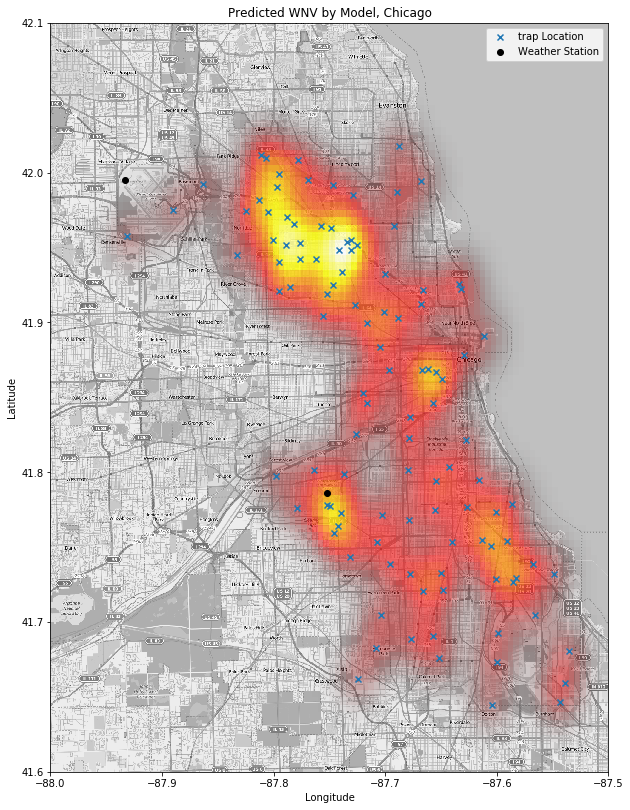

In [33]:
mapdata = np.loadtxt("data/mapdata_copyright_openstreetmap_contributors.txt")


alpha_cm = plt.cm.hot
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
sigthings = X_test[X_test['pred'] == 1]
sigthings = sigthings.groupby(['longitude', 'latitude']).max()['pred'].reset_index()
X = sigthings[['longitude', 'latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = sigthings[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='trap Location')
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='K', label='Weather Station')


plt.title('Predicted WNV by Model, Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')


## Conclusions and Recommendations:

There is no vaccine or specific antiviral treatments for West Nile virus infection. In some severe cases, patients need to be hospitalized to receive treatment- such as intravenous fluids, pain medication, and nursing care. In addition to threatening lives, outbreaks of WNV in the United States are very costly in terms of both medical treatment and event control. A case in point is the 2005 outbreak in Sacramento County, California. 163 human cases were reported and the economic impact of the outbreak cost approximately USD2.28 million for medical treatment and loss of productivity of the patients. Vector control including spray procedures and overtime hours was about USD700,000.

Preventive Action We propose to launch education campaigns at hotspot neighbourhoods to nip larvae growth in the bud. Besides inculcating proactive behaviour and habits to remove stagnant water, broadcasting information to self-protect during days/ months where mosquito count is expected to peak will also help to mitigate WNV infections.
In conclusion, our model may help to identify when and where in Chicago will be vulnerable to WNV. In doing so, we hope to bring down the expenditure associated with spraying by providing accurate information on where and when spraying is required. Targeted spraying as compared to random and massed spraying is less harmful for the environment as well.

## Limitations

Our model is not without limitations. Firstly, the highly imbalanced data set may have hindered our models performance. Unfortunately, our model was unable to beat the baseline accuracy of 94.7%. Our model yield an accuracry score of 83.6%. Despite this shortfall, our model would have still perform better than the naive guess as accuracy scores are poor evaluation metrics for highly imbalanced class. The baseline model would have yeild an extremely low recall while having high specificity due to the imbalanced classes. Thus, the baseline accuracy scores will only capture classes we are not interested in. As such, we evaluated that beating the baseline was the not as important and that our team will take the ROC-AUC as the main evaluation metric. 

One of the solutions to this is to get more data. Another might be to explore other features or engineer different features. A time-series or spatial analysis may also provide us with an additional layer of information that will help us make more accurate predictions. 
Sources:
West Nile Virus Prediction
Economic Cost Analysis of West Nile Virus Outbreak, Sacramento County, California, USA, 2005 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/
https://www.cdc.gov/westnile/symptoms/index.html



![](images/sub.png)